# Machine Learning

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import (GridSearchCV, train_test_split)
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve, roc_auc_score
from sklearn.decomposition import PCA
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier)
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import xgboost as xgb

In [2]:
df_identity = pd.read_csv('train_identity.csv')
df_transaction = pd.read_csv('train_transaction.csv')

In [3]:
# The unique values for the below mentioned columns are 'Found', 'NotFound' or 'New'.
# Hence, updating the string values 'New', 'Found' and 'NotFound' to
# '2', '1' and '0' respectively.
mapValues1 = {'New': 2, 'Found': 1, 'NotFound': 0}
df_identity['id_12'] = df_identity['id_12'].map(mapValues1)
df_identity['id_15'] = df_identity['id_15'].map(mapValues1)
df_identity['id_16'] = df_identity['id_16'].map(mapValues1)
df_identity['id_27'] = df_identity['id_27'].map(mapValues1)
df_identity['id_28'] = df_identity['id_28'].map(mapValues1)
df_identity['id_29'] = df_identity['id_29'].map(mapValues1)

# For below mentioned columns updating the string values 'T' and 'F' to
# '1' and '0' respectively.
mapValues2 = {'T': 1, 'F': 0}
df_identity['id_35'] = df_identity['id_35'].map(mapValues2)
df_identity['id_36'] = df_identity['id_36'].map(mapValues2)
df_identity['id_37'] = df_identity['id_37'].map(mapValues2)
df_identity['id_38'] = df_identity['id_38'].map(mapValues2)

# Since, most of the columns have values as 'NaN' where 'id_35' is equal to 'NaN', hence
# removing those rows from the dataset. This removes only 2.25% of total data
#df1 = df1[df1['id_35'].notnull()]

# Replacing the NaN values of 'DeviceType' column with 'desktop' because as per analysis
# for the mentioned 'DeviceInfo' and its combination with column 'id_31', the device type is equal to 'desktop'
df_identity['DeviceType'].loc[df_identity['DeviceInfo'].isin(['Windows','rv:11.0','Trident/7.0'])] = 'desktop'

####################################################################################

# Adding new column TransactionDay by calculating the value from TransactionDT column
# math.ceil returns smallest integer greater than the provided value.
df_transaction['TransactionDay']=np.ceil(df_transaction['TransactionDT']/60/60/24).astype('int')

# Replacing NaN values of card4 based on common card1 values
df_transaction.loc[df_transaction.card4.isnull(), 'card4'] = \
df_transaction.loc[df_transaction.card4.isnull(), 'card1'].map(df_transaction[df_transaction.card4.notnull()] \
                    [['card1','card4']].sort_values('card1').drop_duplicates().set_index('card1')['card4'])

#Replace few card6 values to valid specific values
df_transaction.card6 = df_transaction.card6.replace(to_replace=['debit or credit'], value=['debit'])
df_transaction.card6 = df_transaction.card6.replace(to_replace=['charge card'], value=['credit'])

# For below mentioned columns updating the string values 'T' and 'F' to
# '1' and '0' respectively.
df_transaction['M1'] = df_transaction['M1'].map(mapValues2)
df_transaction['M2'] = df_transaction['M2'].map(mapValues2)
df_transaction['M3'] = df_transaction['M3'].map(mapValues2)
df_transaction['M5'] = df_transaction['M5'].map(mapValues2)
df_transaction['M6'] = df_transaction['M6'].map(mapValues2)
df_transaction['M7'] = df_transaction['M7'].map(mapValues2)
df_transaction['M8'] = df_transaction['M8'].map(mapValues2)
df_transaction['M9'] = df_transaction['M9'].map(mapValues2)

//anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [4]:
# Creating main dataset by merging both the DataFrames created from two csv files
dataset = pd.merge(df_transaction,df_identity,on='TransactionID',how='left')

In [5]:
dataset.shape
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 590540 entries, 0 to 590539
Columns: 435 entries, TransactionID to DeviceInfo
dtypes: float64(417), int64(5), object(13)
memory usage: 1.9+ GB


In [6]:
dataset.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,1.0,0.0,1.0,1.0,mobile,SAMSUNG SM-G892A Build/NRD90M


In [7]:
# import warnings filter
from warnings import simplefilter, filterwarnings
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)
filterwarnings("error", message=".*check_inverse*.", category=UserWarning, append=False)

In [8]:
def coeff_of_determination(X,Y):
    # Model Intialization
    reg = LogisticRegression()
    # Data Fitting
    reg = reg.fit(X, Y)

    # Model Evaluation
    r2 = reg.score(X, Y)
    return r2

In [9]:
X = np.array([dataset.card1, dataset.C1, dataset.TransactionDay]).T
Y = np.array(dataset.isFraud)
coeff_of_determination(X,Y)

0.9650099908558268

### Applying Logistic Regression to the data on which first Imputation for missing values is performed

In [14]:
Xcols = dataset.drop(['isFraud'],axis=1).select_dtypes(exclude=[object])
y = dataset.isFraud
Xlr, Xtestlr, ylr, ytestlr = train_test_split(Xcols, y, random_state=5,test_size=0.3, stratify = y)
imputer = SimpleImputer(missing_values = np.nan, strategy = 'median')
logReg = LogisticRegression()
steps = [('imputation',imputer),('logistic_regression',logReg)]
pipeline = Pipeline(steps)
pipeline.fit(Xlr,ylr)
pipeline.score(Xtestlr, ytestlr)

//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.9645465731928969

### From below details of the model we can see that the `recall` value is 0 which indicates that the model does not do well in identifying the relevant instance of classification model and in this case which is identifying the fraud transactions.

Train accuracy: 0.9647030079007591
Test accuracy: 0.9645465731928969
The confusion matrix is :
[[170868     95]
 [  6186     13]]
The classification report is :
              precision    recall  f1-score   support

           0       0.97      1.00      0.98    170963
           1       0.12      0.00      0.00      6199

    accuracy                           0.96    177162
   macro avg       0.54      0.50      0.49    177162
weighted avg       0.94      0.96      0.95    177162

The roc_auc_score is : 0.6279138836881863


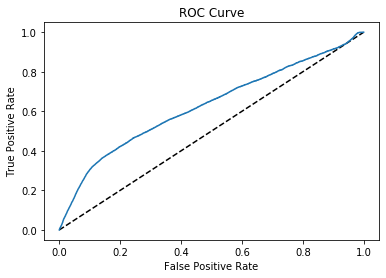

In [16]:
ypred = pipeline.predict(Xtestlr)
y_pred_prob = pipeline.predict_proba(Xtestlr)[:,1]
fpr, tpr, threshold = roc_curve(ytestlr, y_pred_prob)

# Print the accuracy and other details.
print("Train accuracy: {}".format(accuracy_score(pipeline.predict(Xlr), ylr)))
print("Test accuracy: {}".format(accuracy_score(ypred, ytestlr)))
print("The confusion matrix is :")
print(confusion_matrix(ytestlr, ypred))
print("The classification report is :")
print(classification_report(ytestlr, ypred))
print("The roc_auc_score is : {}".format(roc_auc_score(ytestlr, y_pred_prob)))

# Plot ROC curve
_ = plt.plot([0, 1], [0, 1], 'k--')
_ = plt.plot(fpr, tpr)
_ = plt.xlabel('False Positive Rate')
_ = plt.ylabel('True Positive Rate')
_ = plt.title('ROC Curve')

### Here, we are resampling the imbalanced data by performing SMOTE oversampling process.

In [25]:
print("Before resampling, counts of frauds '1': {}".format(sum(ylr == 1))) 
print("Before resampling, counts of non-frauds '0': {} \n".format(sum(ylr == 0))) 

#SMOTE (Synthetic Minority Oversampling Technique) – Oversampling
from imblearn.over_sampling import SMOTE 

imputer = SimpleImputer(missing_values = np.nan, strategy = 'median')
imputer.fit(Xcols)
X = imputer.transform(Xcols)

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=5,test_size=0.3, stratify = y)
sm = SMOTE(random_state = 2) 

Xtrain_overres, ytrain_overres = sm.fit_sample(Xtrain, ytrain) 
  
print('After OverSampling, the shape of train_X: {}'.format(Xtrain_overres.shape)) 
print('After OverSampling, the shape of train_y: {} \n'.format(ytrain_overres.shape)) 
  
print("After OverSampling, counts of frauds '1': {}".format(sum(ytrain_overres == 1))) 
print("After OverSampling, counts of non-frauds '0': {}".format(sum(ytrain_overres == 0))) 

Before resampling, counts of frauds '1': 14464
Before resampling, counts of non-frauds '0': 398914 

After OverSampling, the shape of train_X: (797828, 421)
After OverSampling, the shape of train_y: (797828,) 

After OverSampling, counts of frauds '1': 398914
After OverSampling, counts of non-frauds '0': 398914


### After oversampling, we perform LogisticRegression which improves the `recall` value as compared to previous model.

//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Train accuracy: 0.6696719092335691
Test accuracy: 0.784316049717208
The confusion matrix is :
[[135667  35296]
 [  2915   3284]]
The classification report is :
              precision    recall  f1-score   support

           0       0.98      0.79      0.88    170963
           1       0.09      0.53      0.15      6199

    accuracy                           0.78    177162
   macro avg       0.53      0.66      0.51    177162
weighted avg       0.95      0.78      0.85    177162

The roc_auc_score is : 0.7126156290615903


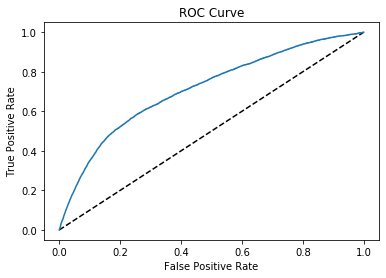

In [21]:
clf = LogisticRegression()
clf.fit(Xtrain_res, ytrain_res)
y_res_pred = clf.predict(Xtest)
y_pred_prob = clf.predict_proba(Xtest)[:,1]
fpr, tpr, threshold = roc_curve(ytest, y_pred_prob)

# Print the accuracy and other details.
print("Train accuracy: {}".format(accuracy_score(clf.predict(Xtrain_res), ytrain_res)))
print("Test accuracy: {}".format(accuracy_score(y_res_pred, ytest)))
print("The confusion matrix is :")
print(confusion_matrix(ytest, y_res_pred))
print("The classification report is :")
print(classification_report(ytest, y_res_pred))
print("The roc_auc_score is : {}".format(roc_auc_score(ytest, y_pred_prob)))

# Plot ROC curve
_ = plt.plot([0, 1], [0, 1], 'k--')
_ = plt.plot(fpr, tpr)
_ = plt.xlabel('False Positive Rate')
_ = plt.ylabel('True Positive Rate')
_ = plt.title('ROC Curve')

### Same process is repeated but this time under sampling is used.

In [22]:
print("Before resampling, counts of frauds '1': {}".format(sum(ylr == 1))) 
print("Before resampling, counts of non-frauds '0': {} \n".format(sum(ylr == 0))) 
  
from imblearn.under_sampling import NearMiss

imputer = SimpleImputer(missing_values = np.nan, strategy = 'median')
imputer.fit(Xcols)
X = imputer.transform(Xcols)

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=5,test_size=0.3, stratify = y)

nr = NearMiss()
Xtrain_res, ytrain_res = nr.fit_sample(Xtrain, ytrain) 
  
print('After UnderSampling, the shape of train_X: {}'.format(Xtrain_res.shape)) 
print('After UnderSampling, the shape of train_y: {} \n'.format(ytrain_res.shape)) 
  
print("After UnderSampling, counts of frauds '1': {}".format(sum(ytrain_res == 1))) 
print("After UnderSampling, counts of non-frauds '0': {}".format(sum(ytrain_res == 0))) 

Before resampling, counts of frauds '1': 14464
Before resampling, counts of non-frauds '0': 398914 

After UnderSampling, the shape of train_X: (28928, 421)
After UnderSampling, the shape of train_y: (28928,) 

After UnderSampling, counts of frauds '1': 14464
After UnderSampling, counts of non-frauds '0': 14464


Train accuracy: 0.7205821349557522
Test accuracy: 0.725370000338673
The confusion matrix is :
[[124924  46039]
 [  2615   3584]]
The classification report is :
              precision    recall  f1-score   support

           0       0.98      0.73      0.84    170963
           1       0.07      0.58      0.13      6199

    accuracy                           0.73    177162
   macro avg       0.53      0.65      0.48    177162
weighted avg       0.95      0.73      0.81    177162

The roc_auc_score is : 0.680914062721084


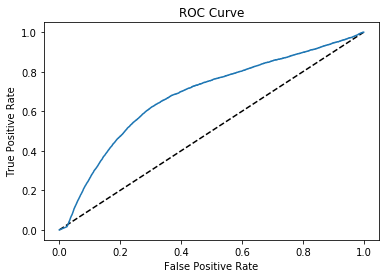

In [23]:
clf = LogisticRegression()
clf.fit(Xtrain_res, ytrain_res)
y_res_pred = clf.predict(Xtest)
y_pred_prob = clf.predict_proba(Xtest)[:,1]
fpr, tpr, threshold = roc_curve(ytest, y_pred_prob)

# Print the accuracy and other details.
print("Train accuracy: {}".format(accuracy_score(clf.predict(Xtrain_res), ytrain_res)))
print("Test accuracy: {}".format(accuracy_score(y_res_pred, ytest)))
print("The confusion matrix is :")
print(confusion_matrix(ytest, y_res_pred))
print("The classification report is :")
print(classification_report(ytest, y_res_pred))
print("The roc_auc_score is : {}".format(roc_auc_score(ytest, y_pred_prob)))

# Plot ROC curve
_ = plt.plot([0, 1], [0, 1], 'k--')
_ = plt.plot(fpr, tpr)
_ = plt.xlabel('False Positive Rate')
_ = plt.ylabel('True Positive Rate')
_ = plt.title('ROC Curve')

__XGBoost is an optimized distributed gradient boosting library designed to be highly efficient, flexible and portable. It implements machine learning algorithms under the Gradient Boosting framework. XGBoost provides a parallel tree boosting (also known as GBDT, GBM) that solve many data science problems in a fast and accurate way.__

In [226]:
from xgboost import XGBClassifier
XGModel = XGBClassifier()
XGModel.fit(Xlr,ylr)
y_XG_pred = XGModel.predict(Xtestlr)
features = XGModel.feature_importances_

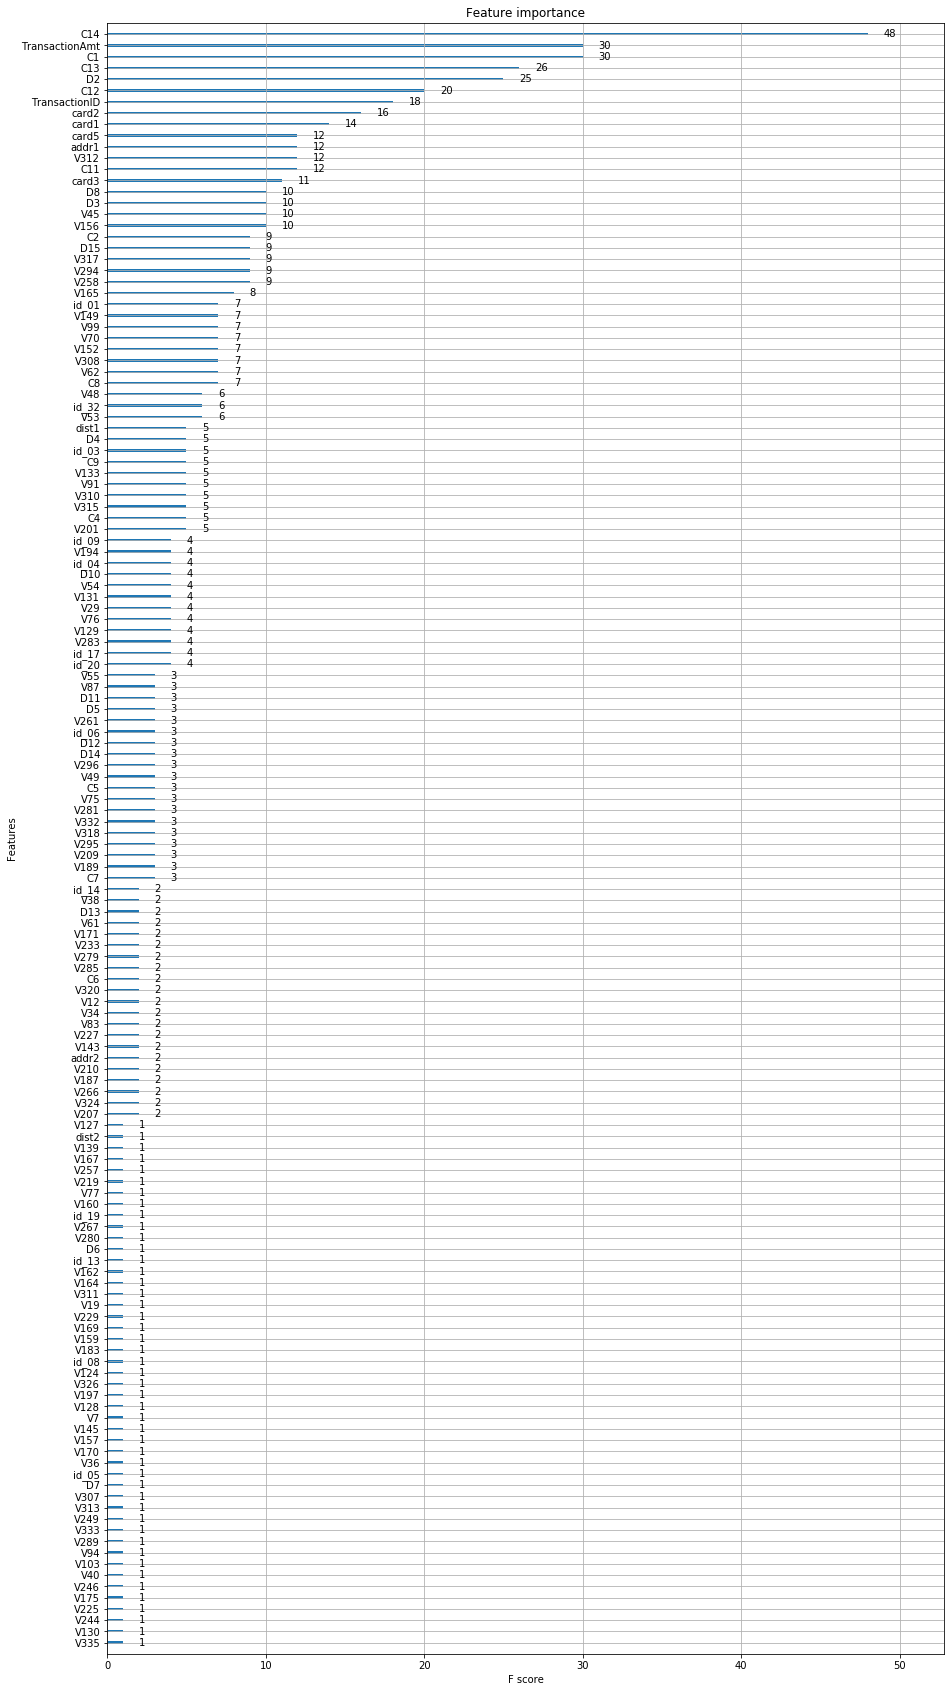

In [227]:
from xgboost import plot_importance
fig, ax = plt.subplots(figsize=(15, 30))
featureDict = XGModel.get_booster().get_fscore()   
_ = plot_importance(XGModel, ax=ax) #total 421 features

In [24]:
#params = {'n_estimators': 300,
#          'learning_rate': 0.01}
#impute = SimpleImputer(missing_values = np.nan, strategy = 'most_frequent')
#GBModel = GradientBoostingClassifier()
#step = [('Imputer',impute),('Gradient_Classifier',GBModel)]
#pipeline2 = Pipeline(step)
#pipeline2.fit(Xlr, ylr)
#y_GB_pred = pipeline2.predict(Xtestlr)

# Plot feature importance
#feature_importance = pipeline2.feature_importances_

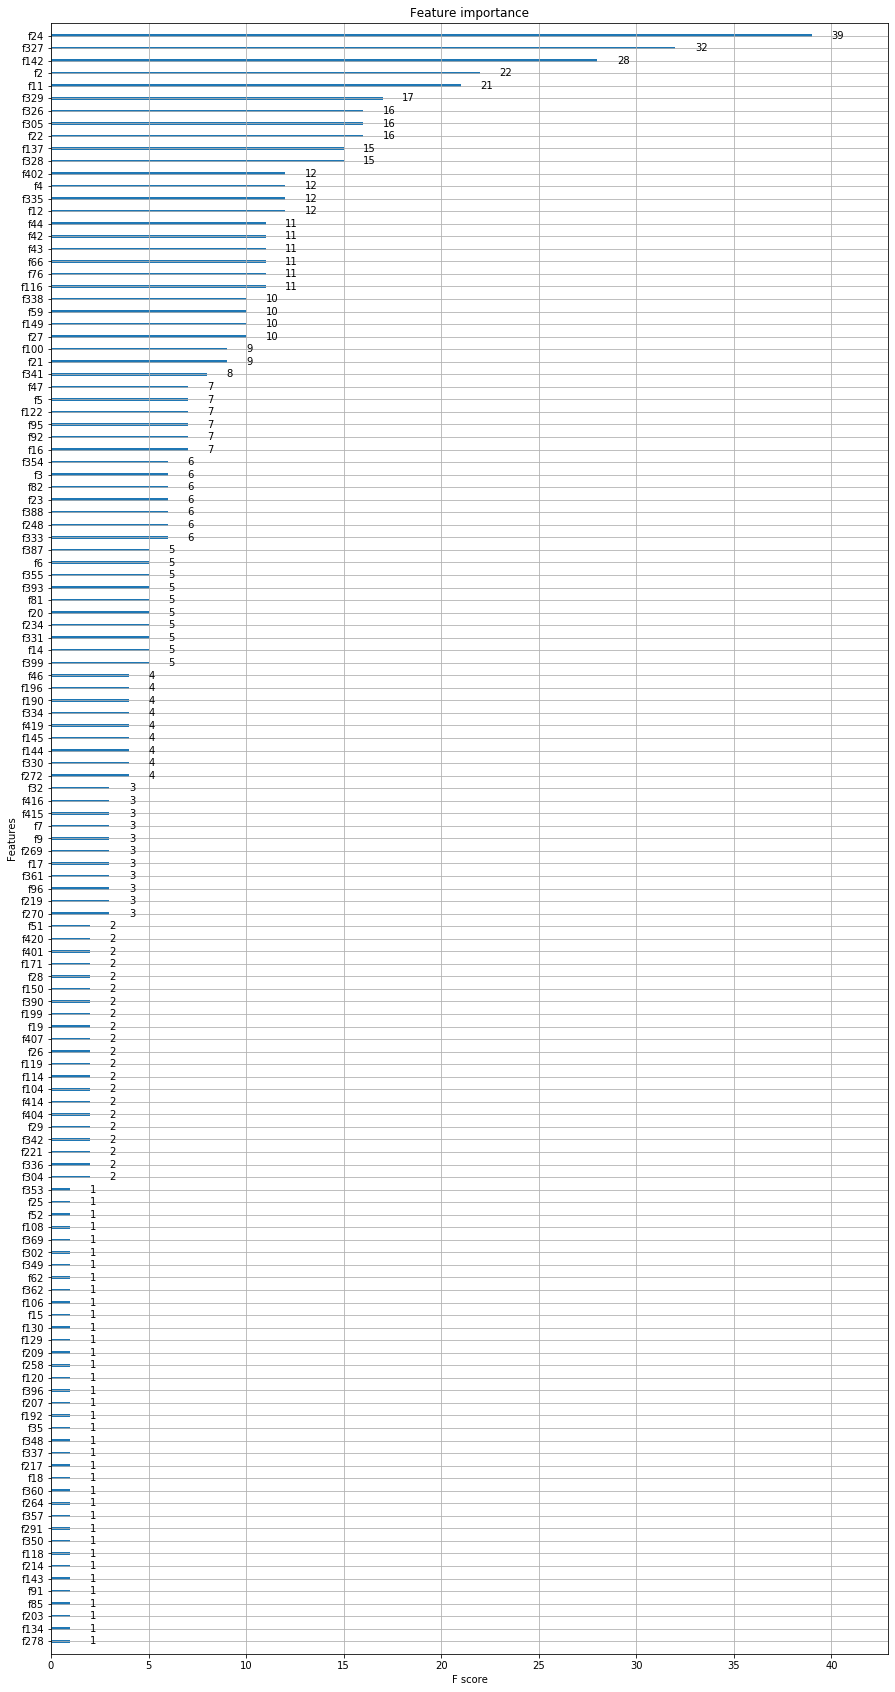

In [28]:
from xgboost import XGBClassifier
from xgboost import plot_importance

XGModel2 = XGBClassifier()
XGModel2.fit(Xtrain_overres,ytrain_overres)
#y_XG_pred = XGModel.predict(Xtestlr)
features2 = XGModel2.feature_importances_

fig, ax = plt.subplots(figsize=(15, 30))
featureDict = XGModel2.get_booster().get_fscore()   
_ = plot_importance(XGModel2, ax=ax) #total 421 features

Train accuracy: 0.9700612162019884
Test accuracy: 0.9648739571691446
The confusion matrix is :
[[168629   2334]
 [  3889   2310]]
The classification report is :
              precision    recall  f1-score   support

           0       0.98      0.99      0.98    170963
           1       0.50      0.37      0.43      6199

    accuracy                           0.96    177162
   macro avg       0.74      0.68      0.70    177162
weighted avg       0.96      0.96      0.96    177162

The roc_auc_score is : 0.8653496986430842


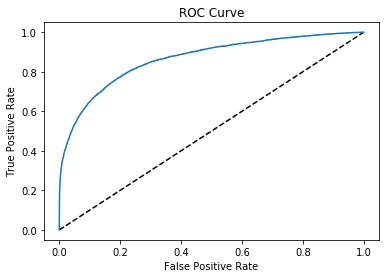

In [50]:
y_XG2_pred = XGModel2.predict(Xtest)
y_XG2_prob = XGModel2.predict_proba(Xtest)[:,1]
fpr, tpr, threshold = roc_curve(ytest, y_XG2_prob)

# Print the accuracy and other details.
print("Train accuracy: {}".format(accuracy_score(XGModel2.predict(Xtrain_overres), ytrain_overres)))
print("Test accuracy: {}".format(accuracy_score(y_XG2_pred, ytest)))
print("The confusion matrix is :")
print(confusion_matrix(ytest, y_XG2_pred))
print("The classification report is :")
print(classification_report(ytest, y_XG2_pred))
print("The roc_auc_score is : {}".format(roc_auc_score(ytest, y_XG2_prob)))

# Plot ROC curve
_ = plt.plot([0, 1], [0, 1], 'k--')
_ = plt.plot(fpr, tpr)
_ = plt.xlabel('False Positive Rate')
_ = plt.ylabel('True Positive Rate')
_ = plt.title('ROC Curve')